## Importación de librerías

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os
from sklearn.metrics import accuracy_score


## Añadiendo rutas y creación de dataframe

In [6]:
# Configuración de rutas
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)  
data_dir = os.path.join(project_root, "data")
file_path = os.path.join(data_dir, "")
raw_data_path = os.path.join(data_dir, "raw_data.csv")
process_data_path = os.path.join(data_dir, "dataset_procesado.csv")

# Cargar los datos
df = pd.read_csv(process_data_path)

___

**Target**

- Dropout  = 0
- Graduate = 1 
- Enrolled = 2   

## Entrenamiento datos

#### Aplicación de PCA

normalización de datos y aplicación de PCA

- Reducir colinealidad (los componentes son ortogonales (independientes o no relacionados entre sí) ).
- Mejorar el rendimiento.
- Reduce ruido y sobreajuste.

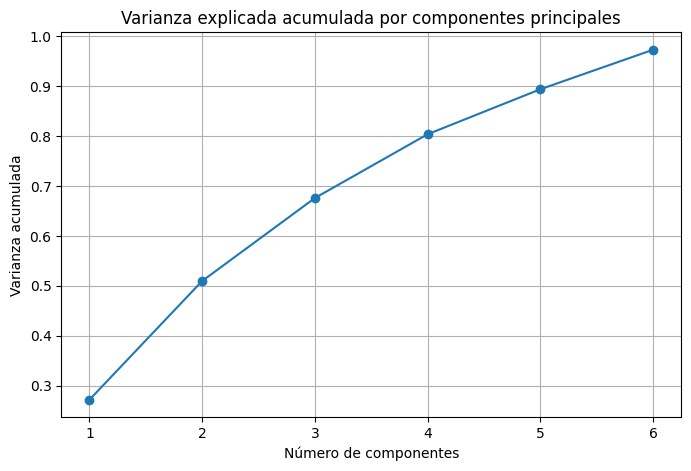

Se seleccionaron 6 componentes que explican el 95% de la varianza.


In [ ]:
# Variables relevantes
features = [
    'curricular_units_1st_sem_(credited)', 
    'curricular_units_1st_sem_(grade)',
    'curricular_units_2nd_sem_(credited)', 
    'curricular_units_2nd_sem_(grade)',
    'age_at_enrollment', 
    'application_order', 
    'unemployment_rate', 
    'gdp'
]

X = df[features]
y = df['target']  

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=0.95)  # Mantener el 95% de la varianza
X_pca = pca.fit_transform(X_scaled)

# Varianza explicada
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Varianza explicada acumulada por componentes principales')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.grid(True)
plt.show()

print(f"Se seleccionaron {pca.n_components_} componentes que explican el 95% de la varianza.")


Métrica          | Significado
-----------------|--------------------------------------------------------------------------------------
**Precision**    | % de predicciones correctas entre todas las que el modelo dijo que eran de esa clase.
**Recall**       | % de casos reales de esa clase que el modelo detectó correctamente.
**F1-Score**     | Media armónica entre Precision y Recall. Ofrece un balance entre ambos.
**Support**      | Número de muestras reales de esa clase en el conjunto de prueba.
**accuracy**     | Exactitud global del modelo → % de casos bien clasificados.
**macro avg**    | Promedio simple de las métricas para todas las clases (sin ponderar).
**weighted avg** | Promedio ponderado (teniendo en cuenta el número de muestras de cada clase).

In [19]:
# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Entrenar modelo
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predicción y evaluación
y_pred = rf.predict(X_test)
print("Reporte con PCA:\n")
print(classification_report(y_test, y_pred))

# Evaluar el rendimiento del modelo
y_test_pred = rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Porcentaje de ajuste del modelo (precisión en prueba): {test_accuracy:.2%}")

# En conclusión, el PCA ha reducido la dimensionalidad de los datos y ha permitido entrenar un modelo de Random Forest con un rendimiento no muy aceptable.

Reporte con PCA:

              precision    recall  f1-score   support

           0       0.69      0.61      0.65       441
           1       0.65      0.79      0.72       642
           2       0.30      0.20      0.24       245

    accuracy                           0.62      1328
   macro avg       0.55      0.53      0.53      1328
weighted avg       0.60      0.62      0.60      1328

Porcentaje de ajuste del modelo (precisión en prueba): 62.12%


#### Comparando modelo sin PCA

In [23]:
# Comparación directa con las variables originales
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
rf_orig = RandomForestClassifier(random_state=42)
rf_orig.fit(X_train_o, y_train_o)
y_pred_orig = rf_orig.predict(X_test_o)

print("Reporte sin PCA:\n")
print(classification_report(y_test_o, y_pred_orig))

# Evaluar el rendimiento del modelo
y_pred_orig = rf_orig.predict(X_test_o)
test_accuracy_o = accuracy_score(y_test_o, y_pred_orig)
print(f"Porcentaje de ajuste del modelo (precisión en prueba): {test_accuracy_o:.2%}")

Reporte sin PCA:

              precision    recall  f1-score   support

           0       0.67      0.64      0.65       441
           1       0.69      0.86      0.76       642
           2       0.44      0.20      0.27       245

    accuracy                           0.66      1328
   macro avg       0.60      0.56      0.56      1328
weighted avg       0.64      0.66      0.64      1328

Porcentaje de ajuste del modelo (precisión en prueba): 66.11%


## Segundo intento

### Generar datos sintéticos para balancear la carga de los datos

In [13]:
df['target'].value_counts()


target
1    2209
0    1421
2     794
Name: count, dtype: int64

In [25]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# X = características, y = target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Entrenamiento con datos balanceados
modelo_bal = RandomForestClassifier(random_state=42)
modelo_bal.fit(X_train_bal, y_train_bal)

# Predicciones con sufijo 
y_pred_bal = modelo_bal.predict(X_test)  # Evaluamos con el test original

# Evaluación del modelo balanceado
print("Reporte con datos balanceados con SMOTE:\n")
print(classification_report(y_test, y_pred_bal))

# Precisión global
accuracy_bal = accuracy_score(y_test, y_pred_bal)
print(f"\nPorcentaje de ajuste del modelo con SMOTE: {accuracy_bal:.2%}")

Reporte con datos balanceados con SMOTE:

              precision    recall  f1-score   support

           0       0.67      0.61      0.64       284
           1       0.73      0.74      0.74       442
           2       0.28      0.31      0.29       159

    accuracy                           0.62       885
   macro avg       0.56      0.55      0.55       885
weighted avg       0.63      0.62      0.62       885


Porcentaje de ajuste del modelo con SMOTE: 62.15%


## Tercer intento

<Axes: xlabel='x', ylabel='y'>

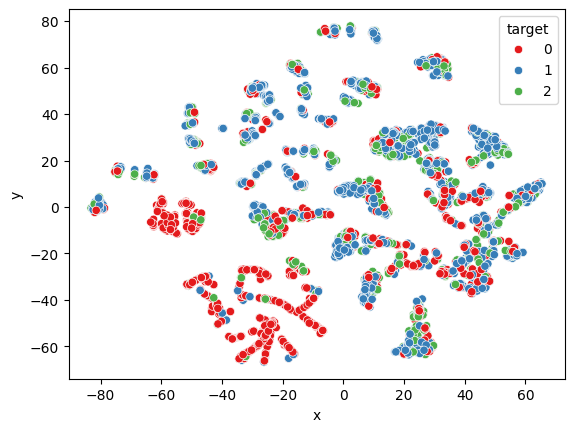

In [28]:
from sklearn.manifold import TSNE
import seaborn as sns

X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_scaled)
df_tsne = pd.DataFrame(X_tsne, columns=['x', 'y'])
df_tsne['target'] = y

sns.scatterplot(data=df_tsne, x='x', y='y', hue='target', palette='Set1')


Podemos observar que, aunque el modelo de Random Forest alcanza una precisión aceptable en términos generales (alrededor del 60 %), su rendimiento no es equilibrado entre las clases. Tiende a predecir mayoritariamente una o dos categorías (Dropout y Graduated), mientras que tiene un desempeño claramente inferior en detectar correctamente a "Enrolled". Esta falta de balance —reflejada en métricas como la *recall* o el *f1-score* más bajos para ciertas clases— sugiere que Random Forest no está capturando bien las diferencias entre los perfiles. Por tanto, aunque es un modelo robusto, no parece ser la mejor opción para esta tarea multiclase sin un tratamiento adicional de los datos o sin considerar modelos alternativos más sensibles a desequilibrios en las clases.
